In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import random
import os
import time

In [179]:
class Data:
    def __init__(self, name, iso):
        self.name = name
        self.iso = iso
        self.democracy = None
        self.human_index = None
        self.exchange_with = []
    
    def __str__(self):
        return f"name\tiso\n{self.name}\t{self.iso}"
    
    def __bool__(self):
        return  self.name is not None and \
                self.iso is not None and \
                self.democracy is not None and \
                self.human_index is not None and \
                self.exchange_with is not None
    
    def contains_data(self):
        return self.democracy is not None or self.human_index is not None or self.exchange_with is not None
    
    def copy(self):
        ret_val = Data(self.name, self.iso)
        ret_val.democracy = self.democracy
        ret_val.human_index = self.human_index
        ret_val.exchange_with = self.exchange_with.copy()
        return ret_val

    
class DF:
    def __init__(self, names, iso):
        assert len(names) == len(iso)
        self.names = names
        self.iso = iso
        self.data = []
        self.iso_to_ind = {}
        self.name_to_ind = {}
        i = 0
        for iso_name, name in zip(self.iso, self.names):
            if iso_name in self.iso_to_ind:
                self.name_to_ind[name] = self.iso_to_ind[iso_name]
            else:
                self.iso_to_ind[iso_name] = i
                self.name_to_ind[name] = i
                self.data.append(Data(name, iso_name))
                i += 1
        self.dummy = Data("", "")
        
    # вернуть Data по имени
    def get_by_name(self, name):
        if name not in self.name_to_ind:
            print(f"{name} not found in self.name_to_ind")
            return self.dummy
        return self.data[self.name_to_ind[name]]
    
    # вернуть Data по iso
    def get_by_iso(self, iso_name):
        if iso_name not in self.iso_to_ind:
            print(f"{iso_name} not found in self.iso_to_ind")
            return self.dummy
        return self.data[self.iso_to_ind[iso_name]]
    
    # построение input.txt
    def build_input(self, k, stimul, show_errors):
        self.k = k
        if show_errors:
            for x in self.data:
                if x.contains_data() and not x:
                    if x.democracy is None:
                        print(f"Отсутствует democracy у {x.name} {x.iso}")
                    if x.human_index is None:
                        print(f"Отсутствует human_index у {x.name} {x.iso}")
                    if not x.exchange_with:
                        print(f"Отсутствует exchange_with у {x.name} {x.iso}")
        data = [x.copy() for x in self.data if x]
        for i, country in enumerate(data):
            for destination in country.exchange_with:
                if destination not in self.name_to_ind:
                    if show_errors:
                        print(f"{name} not found in self.name_to_ind")
                    continue
                country.exchange_with[i] = self.name_to_ind[destination]
            country.exchange_with = set(country.exchange_with)
        
        # для format_output
        self.used_data_index = [i for i in range(len(self.data)) if self.data[i]]
        n = len(data)
        democracy = np.array([x.democracy for x in data])
        democracy = (democracy - democracy.mean()) / democracy.std()
        human_index = np.array([x.human_index for x in data])
        human_index = (human_index - human_index.mean()) / human_index.std()
        exchange_with = [x.exchange_with for x in data]
        if show_errors:
            print("democracy:")
            print(democracy)
            print("human_index")
            print(human_index)
        matrix = [[0] * n for i in range(n)]
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
#                 matrix[j][i] = democracy[i] * democracy[j] + human_index[i] * human_index[j] + stimul
                if i in exchange_with[j] or j in exchange_with[i]:
                    matrix[i][j] = 1
                el
        with open('input.txt', 'w') as file:
            print(n, k, file=file)
            for row in matrix:
                print(*row, file=file)
                
    # обработка output.txt
    def format_output(self):
        with open("output.txt") as file:
            coalitions = list(map(int, file.readline().split()))
        self.iso_to_coalition = {}
        self.coalition_to_countries = [[] for i in range(self.k)]
        for used_index, coalition in zip(self.used_data_index, coalitions):
            iso_name = self.iso[used_index]
            self.coalition_to_countries[coalition].append(self.names[self.iso_to_ind[iso_name]])
            self.iso_to_coalition[iso_name] = coalition
        with open("Data/coalition_to_countries.txt", "w") as file:
            for i in range(self.k):
                print(*self.coalition_to_countries[i], file=file)
                
    # отрисовка
    def plot_output(self):
        colors = ['(230, 25, 75)', '(60, 180, 75)', '(255, 225, 25)', '(0, 130, 200)', '(245, 130, 48)', '(145, 30, 180)',
              '(70, 240, 240)', '(240, 50, 230)', '(210, 245, 60)', '(250, 190, 212)', '(0, 128, 128)',
              '(220, 190, 255)', '(170, 110, 40)', '(255, 250, 200)', '(128, 0, 0)', '(170, 255, 195)', '(128, 128, 0)',
              '(255, 215, 180)', '(0, 0, 128)', '(128, 128, 128)']
        while len(colors) < self.k:
            colors.append(str((random.random(), random.random(), random.random())))
        random.shuffle(colors)
        good_colors = ['(220, 190, 255)',
                       '(145, 30, 180)',
                       '(245, 130, 48)']
        for c in good_colors:
            colors.remove(c)
        colors = good_colors + colors
        for i, color in enumerate(colors):
            color = color[1:-1].split(', ')
            color = tuple(map(lambda x: int(x) / 255, color))
            colors[i] = color
        print("Used colors:")
        for i in range(self.k):
            print(tuple(map(lambda x: round(x * 255), colors[i])))
        plt.figure(figsize=(15, 10), dpi=80)
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([-150, 60, -25, 60])

        shpfilename = shpreader.natural_earth(resolution='110m',
                                              category='cultural',
                                              name='admin_0_countries')
        reader = shpreader.Reader(shpfilename)
        countries = reader.records()
        for country in countries:
            iso_name = country.attributes['ADM0_A3']
            if iso_name in self.iso_to_coalition:
                color = colors[self.iso_to_coalition[iso_name]]
                ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                                  facecolor=color,
                                  label=country.attributes['ADM0_A3'])
            else:
                pass
#                 print(f"Нет никаких данных о стране {iso_name} в plot_output")
        # ax.add_feature(cartopy.feature.LAND)
        ax.add_feature(cartopy.feature.OCEAN)
        # ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
        ax.add_feature(cartopy.feature.LAKES, alpha=0.95)
#         ax.add_feature(cartopy.feature.RIVERS)
        plt.show()
    
    def print_coalitions(self):
        print(*self.coalition_to_countries, sep='\n\n')

In [180]:
# read iso
# added after Brunei
names = []
iso = []
with open("Data/iso.txt", encoding='utf-8') as file:
    for line in file:
        # ISO  NAME
        line = line.strip().split("  ")
        iso.append(line[0])
        names.append(line[1])
df = DF(names, iso)

In [181]:
# read democracy index
# source https://en.wikipedia.org/wiki/Democracy_Index
tables = pd.read_html("https://en.wikipedia.org/wiki/Democracy_Index")
table = tables[5]
print(table[['Country', '2020']])
names = table['Country'].to_list()
democracy_index = table['2020'].to_list()
for name, index in zip(names, democracy_index):
    df.get_by_name(name).democracy = index

           Country  2020
0           Canada  9.24
1    United States  7.92
2          Austria  8.16
3          Belgium  7.51
4           Cyprus  7.56
..             ...   ...
162       Tanzania  5.10
163           Togo  2.80
164         Uganda  4.94
165         Zambia  4.86
166       Zimbabwe  3.16

[167 rows x 2 columns]


In [182]:
# read human index
# source "https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D1%82%D1%80%D0%B0%D0%BD_%D0%BF%D0%BE_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%83_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D0%B7%D0%B2%D0%B8%D1%82%D0%B8%D1%8F"

# table = pd.read_excel("2020_Statistical_Annex_Table_1.xlsx")
table = pd.read_csv("Data/human_development.txt", sep='\t', header=None)
table = table.drop(0, axis=1)
print(table)
names = table[1].to_list()
democracy_index = table[2].to_list()
for name, index in zip(names, democracy_index):
    df.get_by_name(name).human_index = index

               1      2
0         Norway  0.957
1        Ireland  0.955
2    Switzerland  0.955
3      Hong Kong  0.949
4        Iceland  0.949
..           ...    ...
189   San Marino  0.944
190         КНДР  0.766
191        Nauru  0.663
192       Tuvalu  0.583
193      Somalia  0.284

[194 rows x 2 columns]


In [183]:
# read diplomatic exchange

# table = pd.read_excel("Data/Diplomatic_Exchange_V3.16.16.xlsx")
# table.to_csv("Data/Diplomatic_Exchange_V3.16.16.csv", index=False)

table = pd.read_csv("Data/Diplomatic_Exchange_V3.16.16.csv")
table = table[table['Year'] >= 1995]
table = table[['Destination', 'Country']]
pairs = table.values.tolist()
table

,Destination,Country
267605,Afghanistan,Austria
267606,Afghanistan,Bangladesh
267607,Afghanistan,Bulgaria
267608,Afghanistan,China
267609,Afghanistan,Cuba
...,...,...
424370,Zimbabwe,Switzerland
424371,Zimbabwe,"Tanzania, United Republic of"
424372,Zimbabwe,United Kingdom
424373,Zimbabwe,United States


In [184]:
# print(table['Country'].unique())
# print(table['Destination'].unique())
# print(table.values.tolist()[0:10])

In [185]:
for destination, country in pairs:
    df.get_by_name(country).exchange_with.append(destination)

Korea, Democratic People’s Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Macedonia not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Côte d’Ivoire not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Côte d’Ivoire not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in 

Russian Federation not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Côte d’Ivoire not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Russian Fed

Moldova, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Côte d’Ivoire not found in self.name_to_ind
Gambia, The not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Lao People’s Democratic Republic not found in self.name_to_ind
Macedonia not found in self.name_to_ind
Moldova, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Samoa (Formerly Western Samoa) not found in self.name_to_ind
Swaziland not found in self.name_to_ind
Tanzania, United Republic of not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federa

Korea, Republic of not found in self.name_to_ind
Lao People’s Democratic Republic not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Macedonia not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Côte d’Ivoire not found in self.name_to_ind
Gambia, The not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Congo-Kinshasa of the not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Swaziland not found in self.name_to_ind
Tanzania, United Republic of not found in self.name_to_ind
Timor Leste not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Lao People’s Demo

Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Viet Nam not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind
Korea, Democratic People’s Republic of not found in self.name_to_ind
Korea, Republic of not found in self.name_to_ind
Russian Federation not found in self.name_to_ind
Holy See (Vatican) not found in self.name_to_ind


Used colors:
(220, 190, 255)
(145, 30, 180)
(245, 130, 48)


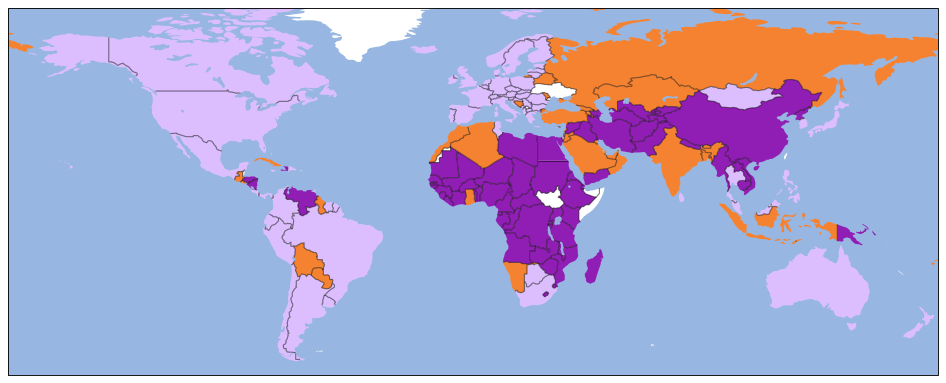

['Albania', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Bulgaria', 'Brazil', 'Botswana', 'Canada', 'Switzerland', 'Chile', 'Colombia', 'Cape Verde', 'Costa Rica', 'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Dominican Republic', 'Ecuador', 'Spain', 'Estonia', 'Finland', 'France', 'United Kingdom', 'Greece', 'Hong Kong', 'Croatia', 'Hungary', 'Ireland', 'Iceland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'South Korea', 'Sri Lanka', 'Lithuania', 'Luxembourg', 'Latvia', 'Mexico', 'North Macedonia', 'Malta', 'Montenegro', 'Mongolia', 'Mauritius', 'Malaysia', 'Netherlands', 'Norway', 'New Zealand', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Singapore', 'Serbia', 'Suriname', 'Slovakia', 'Slovenia', 'Sweden', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Uruguay', 'United States', 'South Africa']

['Afghanistan', 'Angola', 'Azerbaijan', 'Burundi', 'Benin', 'Burkina Faso', 'Central African Republic', 'China', 'Ivory Coast', 'Cameroon', 'Democratic Republic of 

In [186]:
df.build_input(k=3, stimul=-1, show_errors=False)

with open("output.txt", "w") as file:
    print('#', end='', file=file)
time.sleep(0.1)

simple = True

if simple:
    open_file = "simple"
else:
    open_file = "difficult"
os.startfile("executable\\" + open_file)

while True:
    time.sleep(0.3)
    with open("output.txt") as file:
        if file.readline() != "#":
            break
df.format_output()
df.plot_output()
df.print_coalitions()